In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

In [4]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [5]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [6]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [7]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [8]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))

In [12]:
# Function to load precipitation data
def load_tas_data(source_id, expt_id):
    """
    Load tas data for given source and expt ids
    """
    uri = df_mon_tas[(df_mon_tas.source_id == source_id) &
                         (df_mon_tas.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [13]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all'):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
    # Area weighting
    latr = np.deg2rad(data_tmp['hist'].lat)
    # Use the cosine of the converted latitudes as weights for the average
    weights = np.cos(latr)

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
    mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [14]:

tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_tas_data(mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp = load_tas_data(mod_name, experiment_ids[1])
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]])
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting MIROC6

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
MIROC6 processed!


Starting CESM2

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time 

In [16]:
pd.DataFrame(tresults)

,MIROC6,CESM2,BCC-ESM1,MRI-ESM2-0,CanESM5,CAMS-CSM1-0,GFDL-ESM4,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR
t2011,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2031,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2041,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2051,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2061,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2071,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]


In [21]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [22]:
tresults_new

{'MIROC6': {'t2011': 0.6976035808199867,
  't2021': 0.9241407659164906,
  't2031': 1.235913284872879,
  't2041': 1.5333446750318558,
  't2051': 1.861462285562311,
  't2061': 2.1434135099715945,
  't2071': 2.475390628014395},
 'CESM2': {'t2011': 1.094390598544635,
  't2021': 1.3375937706218792,
  't2031': 1.6569418225626578,
  't2041': 2.02734796511902,
  't2051': 2.4850242851507574,
  't2061': 3.025131541509893,
  't2071': 3.5409950092355302},
 'BCC-ESM1': {'t2011': 1.0801761490631065, 't2021': 1.2820887939342356},
 'MRI-ESM2-0': {'t2011': 1.0239186884169271,
  't2021': 1.2678370524898241,
  't2031': 1.6142750920263325,
  't2041': 1.9804371803610934,
  't2051': 2.343858082587701,
  't2061': 2.6897764310137973,
  't2071': 3.0422235839063774},
 'CanESM5': {'t2011': 1.4386232260013685,
  't2021': 1.8637849650586986,
  't2031': 2.394865857677871,
  't2041': 2.996470370599411,
  't2051': 3.5794180205155612,
  't2061': 4.184961774420344,
  't2071': 4.787036799847726},
 'CAMS-CSM1-0': {'t2011

In [23]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [24]:
pd.read_csv('tresults.csv',index_col=0)

,MIROC6,CESM2,BCC-ESM1,MRI-ESM2-0,CanESM5,CAMS-CSM1-0,GFDL-ESM4,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR
t2011,0.697604,1.094391,1.080176,1.023919,1.438623,0.585576,0.812851,1.021362,1.007804,0.964405
t2021,0.924141,1.337594,1.282089,1.267837,1.863785,0.772982,1.021594,1.346130,1.271294,1.241890
t2031,1.235913,1.656942,NaN,1.614275,2.394866,0.993943,1.295160,1.789764,1.642219,1.599642
t2041,1.533345,2.027348,NaN,1.980437,2.996470,1.272332,1.631039,2.248596,2.098605,1.969405
t2051,1.861462,2.485024,NaN,2.343858,3.579418,1.531312,2.001841,2.722717,2.548464,2.325534
t2061,2.143414,3.025132,NaN,2.689776,4.184962,1.834118,2.398149,3.222443,3.027118,2.711012
t2071,2.475391,3.540995,NaN,3.042224,4.787037,2.101574,2.761664,3.826447,3.494716,3.085562


In [157]:
print(len(time_slices))
print(len(tresults))
dt=np.zeros((len(time_slices),len(tresults)))*np.nan

7
10


In [158]:
for model in tresults:
    #print(model)
    timecount=0
    for timeperiod in tresults[model]:
        #print(timeperiod)
        print(tresults[model][timeperiod].dtasG)


<xarray.DataArray 'dtasG' ()>
array(1.0213623, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(1.3461304, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(1.7897644, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(2.2485962, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(2.7227173, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(3.2224426, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(3.8264465, dtype=float32)
<xarray.DataArray 'dtasG' ()>
array(0.96440512)
<xarray.DataArray 'dtasG' ()>
array(1.24188957)
<xarray.DataArray 'dtasG' ()>
array(1.59964209)
<xarray.DataArray 'dtasG' ()>
array(1.96940471)
<xarray.DataArray 'dtasG' ()>
array(2.32553355)
<xarray.DataArray 'dtasG' ()>
array(2.71101181)
<xarray.DataArray 'dtasG' ()>
array(3.08556153)
<xarray.DataArray 'dtasG' ()>
array(1.0943906)
<xarray.DataArray 'dtasG' ()>
array(1.33759377)
<xarray.DataArray 'dtasG' ()>
array(1.65694182)
<xarray.DataArray 'dtasG' ()>
array(2.02734797)
<xarray.DataArray 'dtasG' ()>
array(2.4

In [159]:
modelcount=0
modelnames=[]
for model in tresults:
    #print(model)
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults[model]:
        #print(timeperiod)
        #print(tresults[model][timeperiod].dtasG)
        dt[timecount,modelcount]=tresults[model][timeperiod].dtasG.values.item(0)
        timecount=timecount+1
    modelcount=modelcount+1

In [160]:
dt

array([[1.0213623 , 0.96440512, 1.0943906 , 0.81285141, 0.69760358,
        1.43862323, 1.02391869, 1.08017615, 1.0078036 , 0.58557645],
       [1.34613037, 1.24188957, 1.33759377, 1.02159433, 0.92414077,
        1.86378497, 1.26783705, 1.28208879, 1.27129431, 0.77298177],
       [1.7897644 , 1.59964209, 1.65694182, 1.29515999, 1.23591328,
        2.39486586, 1.61427509,        nan, 1.64221874, 0.99394305],
       [2.24859619, 1.96940471, 2.02734797, 1.63103912, 1.53334468,
        2.99647037, 1.98043718,        nan, 2.09860518, 1.27233195],
       [2.72271729, 2.32553355, 2.48502429, 2.00184055, 1.86146229,
        3.57941802, 2.34385808,        nan, 2.5484642 , 1.53131223],
       [3.22244263, 2.71101181, 3.02513154, 2.39814894, 2.14341351,
        4.18496177, 2.68977643,        nan, 3.02711843, 1.83411814],
       [3.82644653, 3.08556153, 3.54099501, 2.7616643 , 2.47539063,
        4.7870368 , 3.04222358,        nan, 3.49471618, 2.10157417]])

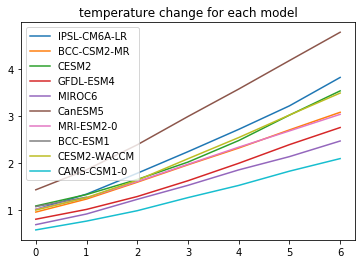

In [161]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [162]:
# Function to load precipitation data
def load_pr_data(source_id, expt_id):
    """
    Load precip data for given source and expt ids
    """
    uri = df_mon_pr[(df_mon_pr.source_id == source_id) &
                         (df_mon_pr.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [163]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all'):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
    # Area weighting
    latr = np.deg2rad(data_tmp['hist'].lat)
    # Use the cosine of the converted latitudes as weights for the average
    weights = np.cos(latr)

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
    mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))
    var_hist = sd_hist ** 2
    var_histG = np.average(var_hist.mean("lon").pr,weights=weights.values)
    sd_histG = np.sqrt(var_histG)
    var_futr = sd_futr ** 2
    var_futrG = np.average(var_futr.mean("lon").pr,weights=weights.values)
    sd_futrG = np.sqrt(var_futrG)
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [1]:

data = {}
results = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_pr_data(mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp = load_pr_data(mod_name, experiment_ids[1])
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}
            for seas in seasons:
                # Calculate means, sds,...
                results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas)
                print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")

NameError: name 'tqdm' is not defined

In [40]:
results

{'BCC-CSM2-MR': {'t2011': {'all': <xarray.Dataset>
   Dimensions:  (lat: 160, lon: 320)
   Coordinates:
     * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
     * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
   Data variables:
       mu_hist  (lat, lon) float32 2.4228807e-06 2.4099031e-06 ... 5.6194244e-06
       mu_futr  (lat, lon) float32 2.88416e-06 2.8741254e-06 ... 6.5202817e-06
       dmuG     float64 1.015
       sd_hist  (lat, lon) float32 1.1514595e-06 1.142341e-06 ... 2.9312864e-06
       sd_futr  (lat, lon) float32 1.3405763e-06 1.333546e-06 ... 3.514154e-06
       dsdG     float64 1.035}}}

In [54]:
results['BCC-CSM2-MR']['t2011']['all']['dmuG']

<xarray.DataArray 'dmuG' ()>
array(1.01494517)